In [27]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install scikit-image


Note: you may need to restart the kernel to use updated packages.


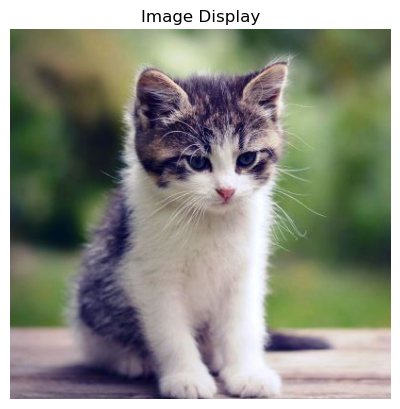

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image file
image = Image.open('./images/cat3.jpg')  # Replace with the path to your image file

# Display the image
plt.imshow(image)
plt.title("Image Display")
plt.axis('off')
plt.show()

# Convert the image to a numpy array (matrix representation)
image_matrix = np.array(image)

# Convert the numpy array back to an Image object
output_image = Image.fromarray(image_matrix)

# Save the image in a new location
output_image.save('./imageDisplay/CAToriginalImage.jpg')

In [9]:
from math import log10, sqrt 
import cv2 
import numpy as np 
  
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [10]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

def compute_color_ssim(image1, image2):
    """
    Compute SSIM (Structural Similarity Index) between two color images.
    
    Parameters:
    - image1: NumPy array of the first image (RGB).
    - image2: NumPy array of the second image (RGB).
    
    Returns:
    - avg_ssim_value: The average SSIM index across color channels.
    - avg_ssim_map: The average SSIM map across color channels.
    """
    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions.")
    
    # Initialize lists to store SSIM values and maps for each channel
    ssim_values = []

    # Calculate SSIM for each color channel
    for channel in range(3):  # Loop over RGB channels
        ssim_value, ssim_map = ssim(image1[..., channel], image2[..., channel], full=True, data_range=255)
        ssim_values.append(ssim_value)

    # Average SSIM values and maps across the channels
    avg_ssim_value = np.mean(ssim_values)
    
    return avg_ssim_value

# Example usage
# Assuming image1 and image2 are loaded as NumPy arrays of shape (height, width, 3)
# ssim_value, ssim_image = compute_color_ssim(image1, image2)


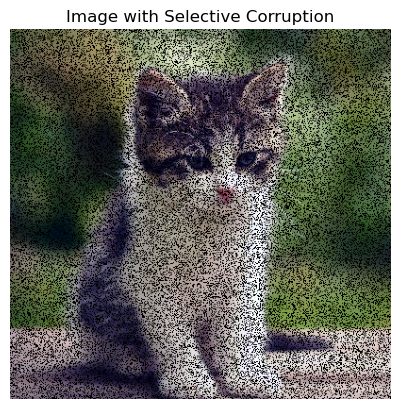

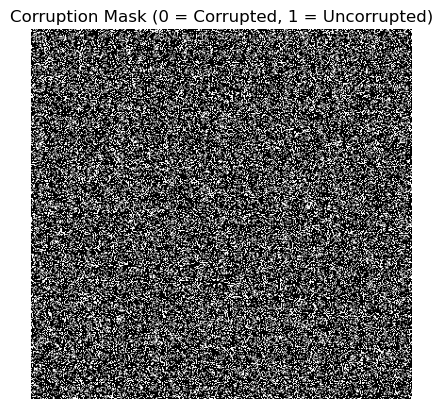

In [4]:

# Generate a 2D mask matrix for corruption
corruption_probability = .3
mask = np.random.choice([0, 1], size=image_matrix.shape[:2], p=[corruption_probability, 1 - corruption_probability])

# Expand the mask to match the image shape (height, width, 3)
mask_expanded = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

# Generate noise only for the corrupted pixels
#noise = np.random.rand(*image_matrix.shape)
#corrupted_image_mat = (image_matrix / 255 + 0.2 * noise * (1 - mask_expanded)) * 255  # Apply noise only to corrupted pixels

corrupted_image_mat = np.where(mask_expanded == 1, image, 0)

# Clip the values to ensure they remain between 0 and 255
corrupted_image_mat = np.clip(corrupted_image_mat, 0, 255).astype(np.uint8)

# Display the corrupted image
plt.imshow(corrupted_image_mat)
plt.title("Image with Selective Corruption")
plt.axis('off')
plt.show()


# Display the mask with 0 as white and 1 as black using vmin and vmax
plt.imshow(mask, cmap='gray_r', vmin=0, vmax=1)
plt.title("Corruption Mask (0 = Corrupted, 1 = Uncorrupted)")
plt.axis('off')
plt.show()

image_mat = corrupted_image_mat

# Convert the numpy array back to an Image object
output_image = Image.fromarray(image_mat)

# Save the image in a new location
output_image.save('./imageDisplay/CATcorruptedImage.jpg')

mask_image = (mask_expanded * 255).astype(np.uint8)  # Scale mask values for visibility
output_mask = Image.fromarray(mask_image)
output_mask.save('./imageDisplay/CATMask.jpg')

In [59]:
from scipy.stats import mode
import numpy as np
import matplotlib.pyplot as plt

def column_imputation(M, mask, impute_strategy='mean'):
    # Convert to float to handle NaN values
    M = M.astype(float)
    M[mask == 0] = np.nan  # Set corrupted pixels to NaN based on mask

    # Impute each column independently
    for col in range(M.shape[1]):
        # Extract the column data (all rows in column `col`)
        column_data = M[:, col]

        # Check for corrupted (NaN) pixels in this column
        corrupted_pixels = np.isnan(column_data)

        # Choose the imputation strategy
        if impute_strategy == 'mean':
            # Calculate the mean of uncorrupted values in the column
            column_impute_value = np.nanmean(column_data)
        elif impute_strategy == 'median':
            # Calculate the median of uncorrupted values in the column
            column_impute_value = np.nanmedian(column_data)
        elif impute_strategy == 'mode':
            # Calculate the mode of uncorrupted values in the column
            column_impute_value = mode(column_data, nan_policy='omit').mode[0]
        else:
            raise ValueError("Unknown imputation strategy: choose 'mean', 'median', or 'mode'")

        # Replace NaNs (corrupted pixels) in the column with the calculated value
        column_data[corrupted_pixels] = column_impute_value

    # Display the image after imputation
    plt.imshow(M.astype(np.uint8))  # Convert back to uint8 for proper display
    plt.title(f"Image Display with Column-{impute_strategy.capitalize()} Imputation")
    plt.axis('off')
    plt.savefig(f"./imageDisplay/CATImageRecoveredby{impute_strategy.capitalize()}.png", format='png')  # You can change the format if needed
    plt.show()
    value = PSNR(image_matrix, M) 
    print(f"PSNR value is {value} dB with {impute_strategy.capitalize()} Imputation") 
    ssim_value = compute_color_ssim(image_matrix, M)
    print(f"SSIM value is {ssim_value} with {impute_strategy.capitalize()} Imputation") 
    M = np.clip(M, 0, 255).astype(np.uint8)
    
    return M
    



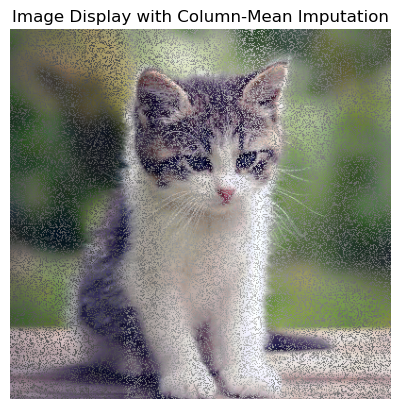

PSNR value is 19.302239315305155 dB with Mean Imputation
SSIM value is 0.40768518259586134 with Mean Imputation


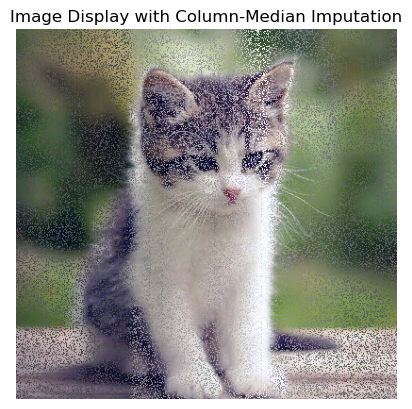

PSNR value is 18.906297408786745 dB with Median Imputation
SSIM value is 0.44171908463903997 with Median Imputation


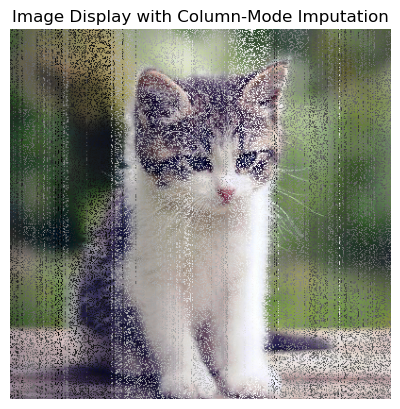

PSNR value is 16.778739023648384 dB with Mode Imputation
SSIM value is 0.3342019041357774 with Mode Imputation


In [61]:
# Example usage
# Assume `corrupted_image_mat` is the corrupted image matrix and `mask` is the 2D mask

column_imputation(corrupted_image_mat, mask, impute_strategy='mean')
column_imputation(corrupted_image_mat, mask,impute_strategy='median')
column_imputation(corrupted_image_mat, mask,impute_strategy='mode');


In [17]:
import numpy as np
import matplotlib.pyplot as plt

def svd_imputation(M, mask, rank=50, max_iters=100, tol=1e-4):
    """
    Perform SVD-based imputation to fill in missing pixels in an image.
    
    Parameters:
    - M: 2D or 3D NumPy array (height x width x channels), the corrupted image matrix
    - mask: 2D NumPy array (height x width), where 1 indicates known pixels, and 0 indicates corrupted pixels
    - rank: int, the rank for the low-rank approximation
    - max_iters: int, the maximum number of iterations
    - tol: float, the convergence tolerance
    
    Returns:
    - M: The image with imputed values in place of corrupted pixels
    """
    # Convert to float for imputation
    M = M.astype(float)
    M_orig = M.copy()

    # Initialize unknown values in the corrupted areas with random values
   # M[mask == 0] = np.random.rand(*M[mask == 0].shape) * 255

    # Repeat until convergence or maximum iterations
    for i in range(max_iters):
        M_prev = M.copy()  # Store the previous image for convergence checking

        # Perform SVD on each color channel separately
        for channel in range(M.shape[2]):
            # Get the SVD of the current channel
            U, S, Vt = np.linalg.svd(M[..., channel], full_matrices=False)
            
            # Keep only the top 'rank' singular values for low-rank approximation
            S = np.diag(S[:rank])
            U = U[:, :rank]
            Vt = Vt[:rank, :]

            # Reconstruct the channel with the low-rank approximation
            M[..., channel] = U @ S @ Vt

        # Re-impose known pixel values (those indicated by mask == 1)
        M[mask == 1] = M_orig[mask == 1]

        # Check for convergence
        if np.linalg.norm(M - M_prev) < tol:
            print(f"Converged in {i + 1} iterations.")
            break

    else:
        print("Reached the maximum number of iterations.")

    

    return M

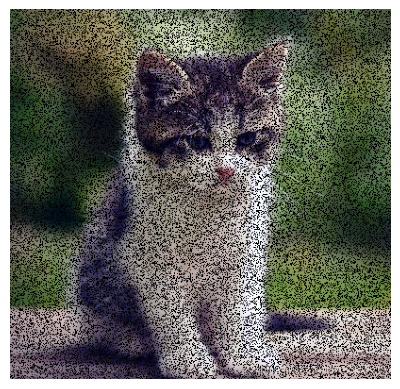

Converged in 20 iterations.
PSNR value is 20.467217749848814 dB with 1 Rank
SSIM value is 0.4563430830297865 with 1 Rank
Reached the maximum number of iterations.
PSNR value is 30.54489325856573 dB with 11 Rank
SSIM value is 0.8793489910398845 with 11 Rank
Reached the maximum number of iterations.
PSNR value is 33.03002845502809 dB with 21 Rank
SSIM value is 0.9317409848553985 with 21 Rank
Reached the maximum number of iterations.
PSNR value is 31.79757160841653 dB with 31 Rank
SSIM value is 0.9313729540369476 with 31 Rank
Reached the maximum number of iterations.
PSNR value is 27.62506353861361 dB with 41 Rank
SSIM value is 0.9046224714799539 with 41 Rank
Reached the maximum number of iterations.
PSNR value is 24.38133668989334 dB with 51 Rank
SSIM value is 0.8734920383541506 with 51 Rank
Reached the maximum number of iterations.
PSNR value is 22.37026368381852 dB with 61 Rank
SSIM value is 0.8377091760234294 with 61 Rank
Reached the maximum number of iterations.
PSNR value is 20.6486

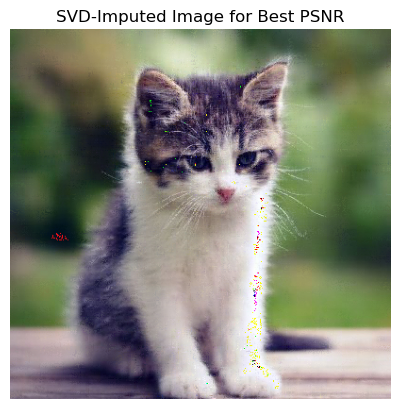

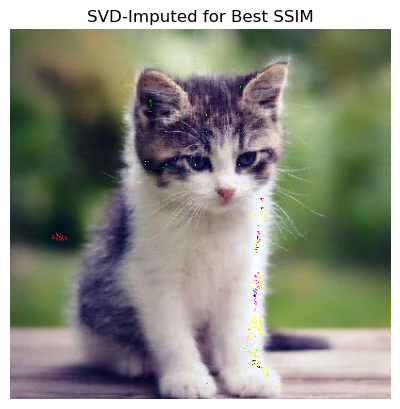

In [63]:
plt.imshow(corrupted_image_mat)
plt.axis('off')
plt.show()

rankL = []
PSNRL = []
SSIML = []
maxPSNR = 0
bestRankPSNR = 0
maxSSIM = 0
bestRankSSIM = -1

MPSNRbest = np.zeros(image_matrix.shape)
MSSIMbest = np.zeros(image_matrix.shape)

for rank in range(1, 101, 10):
    M= svd_imputed_image = svd_imputation(corrupted_image_mat, mask, rank=rank, max_iters=50, tol=1e-4)
    PSNR_value = PSNR(image_matrix, M) 
    print(f"PSNR value is {PSNR_value} dB with {rank} Rank") 
    SSIM_value = compute_color_ssim(image_matrix, M)
    print(f"SSIM value is {SSIM_value} with {rank} Rank")
    if PSNR_value > maxPSNR:
        MPSNRbest = M
        maxPSNR = PSNR_value
        bestRankPSNR = rank
    if SSIM_value > maxSSIM:
        MSSIMbest = M
        maxSSIM = SSIM_value
        bestRankSSIM = rank
    SSIML.append(SSIM_value)
    rankL.append(rank)
    PSNRL.append(PSNR_value)



print(f"The best PSNR value is {maxPSNR} dB with {bestRankPSNR} Rank") 
print(f"The best SSIM value is {maxSSIM} dB with {bestRankSSIM} Rank") 
# Display the result
plt.imshow(MPSNRbest.astype(np.uint8))
plt.title("SVD-Imputed Image for Best PSNR")
plt.axis('off')
plt.show()

plt.imshow(MSSIMbest.astype(np.uint8))
plt.title("SVD-Imputed for Best SSIM")
plt.axis('off')
plt.show()

# Save the best PSNR image
output_image_psnr = Image.fromarray(MPSNRbest.astype(np.uint8))
output_image_psnr.save(f'./imageDisplay/CATBestPSNR_{maxPSNR}dB.jpg')

# Save the best SSIM image
output_image_ssim = Image.fromarray(MSSIMbest.astype(np.uint8))
output_image_ssim.save(f'./imageDisplay/CATBestSSIM_{maxSSIM}.jpg')

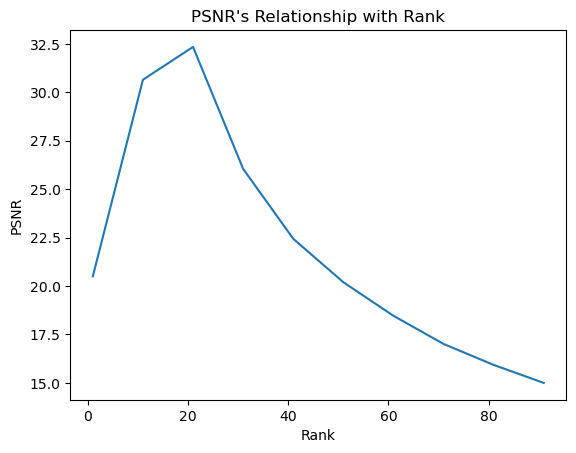

In [21]:
plt.plot(rankL, PSNRL)
plt.title("PSNR's Relationship with Rank")
plt.xlabel("Rank")
plt.ylabel("PSNR")

# Save the plot as an image
plt.savefig('./imageDisplay/PSNR_vs_Rank.png', format='png')  # You can change the format if needed

# Display the plot
plt.show()

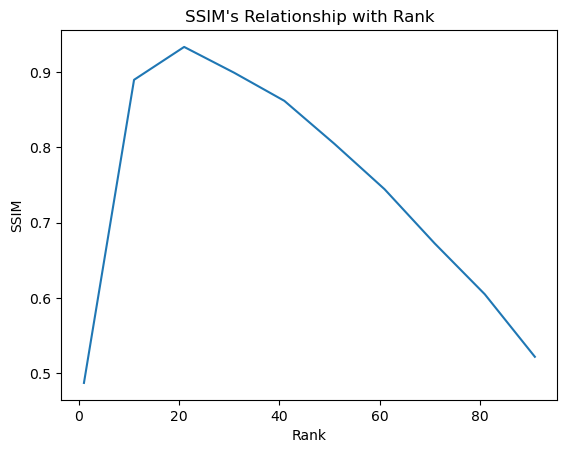

In [23]:
plt.plot(rankL, SSIML)
plt.title("SSIM's Relationship with Rank")
plt.xlabel("Rank")
plt.ylabel("SSIM")

# Save the plot as an image
plt.savefig('./imageDisplay/SSIM_vs_Rank.png', format='png')  # You can change the format if needed

# Display the plot
plt.show()

In [8]:
import cvxpy as cp


variables = []
constraints = []
for i in range(3):
    U = cp.Variable(shape=(image_matrix.shape[0], image_matrix.shape[1]))
    variables.append(U)
    constraints.append(cp.multiply(mask, U) == cp.multiply(mask, corrupted_image_mat[:,:,i]))

prob = cp.Problem(cp.Minimize(cp.tv(*variables)), constraints)
prob.solve(verbose=True, solver=cp.SCS)
print("optimal objective value: {}".format(prob.value))

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 05 09:09:17 PM: Your problem has 475104 variables, 475104 constraints, and 0 parameters.
(CVXPY) Nov 05 09:09:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 05 09:09:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 05 09:09:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 05 09:09:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 05 09:09:17 PM: Compiling problem (target solver=SC

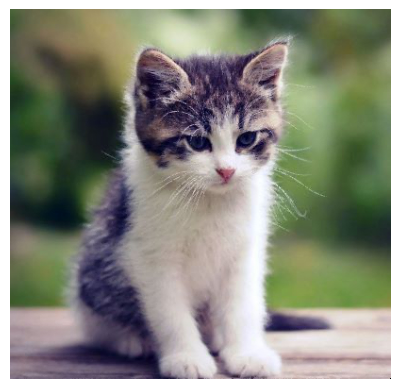

PSNR value is 41.80153520011821
SSIM value is 0.9837580588167688


In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

rec_arr = np.zeros((image_matrix.shape[0], image_matrix.shape[1], 3))
for i in range(3):
    rec_arr[:, :, i] = variables[i].value
rec_arr = np.clip(rec_arr, 0, 255).astype(np.uint8)

plt.imshow(rec_arr)
plt.axis('off')
plt.show()

# Save the difference image
#plt.imsave('./imageDisplay/CATImageRecoveredbyTV.png', rec_arr, cmap='gray')

# Calculate PSNR and SSIM values
PSNR_value = PSNR(image_matrix, rec_arr) 
print(f"PSNR value is {PSNR_value}") 
SSIM_value = compute_color_ssim(image_matrix, rec_arr)
print(f"SSIM value is {SSIM_value}")

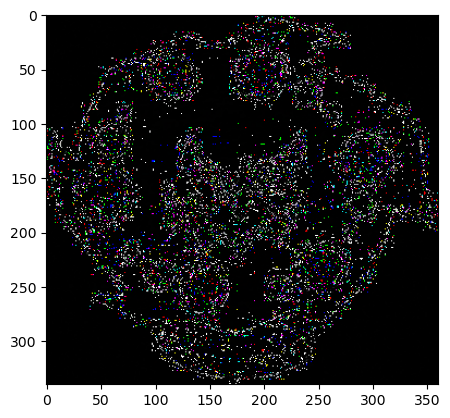

In [39]:
plt.imshow(image_matrix - rec_arr)

In [90]:
rec_arr

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [254, 254, 254],
        [255, 255, 255],
        [254, 254, 254]],

       ...,

       [[254, 254, 254],
        [255, 255, 255],
        [254, 254, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [254, 254, 254]],

       [[255, 255, 255],
        [254, 254, 254],
        [255, 255, 255],
        ...,
        [254, 254, 254],
        [255, 255, 255],
        [254, 254, 254]],

       [[255, 255, 255],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [255, 255, 255],
        [255, 255, 255]]